# Setup

In [1]:
%matplotlib inline

import torch
import random
import copy
import requests #for sending updates to my phone via telegram
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms
from operator import itemgetter
from tqdm import tqdm, tnrange, tqdm_notebook

sns.set()

In [2]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    BOT_TOKEN, CHANNEL = file.read().split('\n')

# Dataloaders

## Clean MNIST loaders

In [3]:
torch.manual_seed(1);

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalise to range -1 to 1
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

## Adversarial loader

In [6]:
class AdversarialDataset(torch.utils.data.Dataset):
    """FGSM adversarials of MNIST test set"""

    def __init__(self, root_dir, transform=None):

        self.adversarials = np.load(root_dir+'/adversarials.npy')
        self.labels = np.load(root_dir+'/labels.npy')
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image = self.adversarials[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return image, label

In [7]:
adversarials = AdversarialDataset('D:/Data_sets/Adversarial/MNIST')

In [8]:
adversarial_loader = torch.utils.data.DataLoader(adversarials, 
                                           batch_size=1000, 
                                           shuffle=True, 
                                           pin_memory=True)

# Hyperparameter space

In [9]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [10]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

# Randomise network

In [11]:
def random_value(space):
    """Returns random value from space."""
    
    val = None
    
    if 'func' in space: #randomise optimiser or activation function
        val = random.sample(space['func'], 1)[0] 
    
    elif isinstance(space['lb'], int): #randomise number of units or layers
        val = random.randint(space['lb'], space['ub'])
    
    else: #randomise percentages, i.e. dropout rates or weight decay
        val = random.random() * (space['ub'] - space['lb']) + space['lb']
    
    return val

In [12]:
def randomize_network(layer_space, net_space): 
    """Returns a randomised neural network"""
    net = {}
    
    for key in net_space.keys():
        net[key] = random_value(net_space[key])
        
    layers = []
    
    for i in range(net['nb_layers']):
        layer = {}
        for key in layer_space.keys():
            layer[key] = random_value(layer_space[key])
        layers.append(layer)
        net['layers'] = layers
        
    return net

In [13]:
randomize_network(LAYER_SPACE, NET_SPACE)

{'layers': [{'activation': 'elu',
   'dropout_rate': 0.1694015325787908,
   'nb_units': 171},
  {'activation': 'relu',
   'dropout_rate': 0.09748066163252285,
   'nb_units': 2000},
  {'activation': 'relu',
   'dropout_rate': 0.46349663176608635,
   'nb_units': 1558}],
 'lr': 0.08417565265630365,
 'nb_layers': 3,
 'optimizer': 'adam',
 'weight_decay': 0.00019268651272456494}

# Mutate network

In [14]:
def mutate_net(nnet, layer_space, net_space):
    
    net = copy.deepcopy(nnet)
    
    
    # mutate optimizer
    for k in ['lr', 'weight_decay', 'optimizer']:
        if random.random() < net_space[k]['mutate']:
            net[k] = random_value(net_space[k])
    
    
    # mutate layers
    for layer in net['layers']:
        for k in layer_space.keys():
            if random.random() < layer_space[k]['mutate']:
                layer[k] = random_value(layer_space[k])
                
                
    # mutate number of layers -- 50% add 50% remove
    if random.random() < net_space['nb_layers']['mutate']:
        if net['nb_layers'] <= net_space['nb_layers']['ub']:
            if random.random()< 0.5 and \
            net['nb_layers'] < net_space['nb_layers']['ub']:
                layer = {}
                for key in layer_space.keys():
                    layer[key] = random_value(layer_space[key])
                net['layers'].append(layer)      
            else:
                if net['nb_layers'] > 1:
                    net['layers'].pop()

                
            # value & id update
            net['nb_layers'] = len(net['layers'])         
            
    return net

# NetBuilder

In [15]:
class Flatten(nn.Module):
    """Flattens input to vector size (batchsize, 1)
    (for use in NetFromBuildInfo)."""

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [16]:
class NetFromBuildInfo(nn.Module):
    def __init__(self, build_info):
        super(NetFromBuildInfo, self).__init__()
        
        self.activation_dict = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU()
            }

        #NETWORK DEFINITION
        
        previous_units = 28 * 28 #MNIST shape
        
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
         
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units'])
                )
            
            previous_units = layer_info['nb_units']
            
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate'])
                )
            if layer_info['activation'] == 'linear':
                continue #linear activation is identity function
            self.model.add_module(
                layer_info['activation']+ i,
                self.activation_dict[layer_info['activation']])

        self.model.add_module(
            'logits',
            nn.Linear(previous_units, 10) #10 MNIST classes
            )
        
        
        ##OPTIMIZER

        self.opt_args = {#'params': self.model.parameters(),
                 'weight_decay': build_info['weight_decay'],
                 'lr': build_info['lr']
                 }
        
        self.optimizer_dict = {
            'adam': optim.Adam(self.model.parameters(),**self.opt_args),
            'rmsprop': optim.RMSprop(self.model.parameters(),**self.opt_args),
            'adadelta':optim.Adadelta(self.model.parameters(),**self.opt_args),
            'sgd': optim.SGD(self.model.parameters(), **self.opt_args, momentum=0.9) #momentum to train faster
            }

        self.optimizer = self.optimizer_dict[build_info['optimizer']]
        
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train test helpers

In [18]:
def train(model, train_loader, optimizer, epoch):
    
    model.train(True)
    
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

    running_loss /= len(train_loader.dataset)    
    
    if epoch % 4 == 0:
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, running_loss ))

In [19]:
def test(model, test_loader):
    
    model.train(False)
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            
            data, target = data.cuda(), target.cuda()
            output = model(data)
            
            test_loss += F.nll_loss(output, target, size_average=False).item()
            
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    
    return (test_loss, correct)

# Evolution optimiser

In [20]:
class TournamentOptimizer:
    """Define a tournament play selection process."""

    def __init__(self, population_sz, layer_space, net_space, init_fn, mutate_fn, builder_fn,
                 train_fn, test_fn, data_loader, test_loader, adversarial_loader):
        
        self.init_fn = init_fn
        self.layer_space = layer_space
        self.net_space = net_space
        self.mutate_fn = mutate_fn
        self.builder_fn = builder_fn
        self.train = train_fn
        self.test = test_fn
        self.dataloader = data_loader
        self.testloader = test_loader
        self.population_sz = population_sz
        self.adversarials = adversarial_loader
        
        torch.manual_seed(1);
        
        self.genomes = [init_fn(self.layer_space, self.net_space) for i in range(population_sz)]   
        self.population = [NetFromBuildInfo(i).cuda() for i in self.genomes] #randomize population of nets     
        
        self.test_results = {} 
        self.genome_history = {} 

        self.generation = 0

    def step(self, generations=1, save=True, phone=False):
        """Tournament evolution step."""

        for _ in tnrange(generations, desc='Overall progress'): #tqdm progress bar
            genome_holder = [] 

            self.generation += 1

            self.genome_history[self.generation] = self.genomes

            self.train_nets(save=save)
            self.evaluate_nets()

            mean = np.mean(self.test_results[self.generation]['correct'])
            best = np.max(self.test_results[self.generation]['correct'])

            tqdm.write('Generation {} Population mean:{} max:{}'
                       .format(self.generation, mean, best))
            
            if phone: #update via telegram
                requests.post("https://api.telegram.org/bot{}/"
                  "sendMessage".format(BOT_TOKEN), 
                  data={'chat_id': '{}'.format(CHANNEL),
                    'text':'Generation {} completed \n'
                        'Population mean: {} max: {}'
                        .format(self.generation, mean, best)})


            children = []
            n_elite = 2
            sorted_pop = np.argsort(self.test_results[self.generation]['correct'])[::-1]
            elite = sorted_pop[:n_elite]



            # elites always included in the next population
            self.elite = []
            print('\nTop performers:')
            for no, i in enumerate(elite):
                self.elite.append((self.test_results[self.generation]['correct'][i], 
                                   self.population[i]))    

                genome_holder.append(self.genomes[i])

                tqdm.write("{}: score:{}".format(no,
                            self.test_results[self.generation]['correct'][i]))   

                children.append(self.population[i])



            #https://stackoverflow.com/questions/31933784/tournament-selection-in-genetic-algorithm
            p = 0.85 # winner probability 
            tournament_size = 3
            probs = [p*((1-p)**i) for i in range(tournament_size-1)]
            probs.append(1-np.sum(probs))
            #probs = [0.85, 0.1275, 0.0224]

            while len(children) < self.population_sz:
                pop = range(len(self.population))
                sel_k = random.sample(pop, k=tournament_size)
                fitness_k = list(np.array(self.test_results[self.generation]['correct'])[sel_k])
                selected = zip(sel_k, fitness_k)
                rank = sorted(selected, key=itemgetter(1), reverse=True)
                pick = np.random.choice(tournament_size, size=1, p=probs)[0]
                best = rank[pick][0]
                genome = self.mutate_fn(self.genomes[best], self.layer_space, self.net_space)

                genome_holder.append(genome)
                model =  self.builder_fn(genome).cuda()
                children.append(model)

                    
            self.population = children
            self.genomes = genome_holder

        
    def train_nets(self, save=True):
        """trains population of nets"""
         
        for i, net in enumerate(tqdm_notebook(self.population)):
            for epoch in range(1, 4):
                torch.manual_seed(1);
                self.train(net, self.dataloader, net.optimizer, epoch)
                
            if save:
                fp = r"D:\Models\NeuroEvolution/{}-{}".format(self.generation, i)
                torch.save(net.state_dict(), fp)
                
                
    def evaluate_nets(self):
        """evaluate the models."""
        
        losses = []
        corrects = []
        clean_corrects = []
        
        self.test_results[self.generation] = {}
        
        for i in range(len(self.population)):
            net = self.population[i]
            loss, correct = self.test(net, self.adversarials) 
            _, clean_correct = self.test(net, self.testloader)
            
            losses.append(loss)
            corrects.append(correct)
            clean_corrects.append(clean_correct)
        
        self.test_results[self.generation]['losses'] = losses
        self.test_results[self.generation]['correct'] = corrects
        self.test_results[self.generation]['clean_correct'] = clean_corrects

# Run 

In [30]:
testing = TournamentOptimizer(30, LAYER_SPACE, NET_SPACE, randomize_network, 
                           mutate_net, NetFromBuildInfo, train, test,
                          train_loader, test_loader, adversarial_loader)

In [31]:
testing.step(generations=50, save=True, phone=True)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 1 Population mean:3003.266666666667 max:5713

Top performers:
0: score:5713
1: score:5313


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 2 Population mean:4383.966666666666 max:6089

Top performers:
0: score:6089
1: score:5779


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 3 Population mean:4797.8 max:6296

Top performers:
0: score:6296
1: score:6028


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 4 Population mean:4845.766666666666 max:6407

Top performers:
0: score:6407
1: score:6042


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 5 Population mean:4927.466666666666 max:6496

Top performers:
0: score:6496
1: score:6415


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 6 Population mean:5463.8 max:6591

Top performers:
0: score:6591
1: score:6559


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 7 Population mean:5165.066666666667 max:6655

Top performers:
0: score:6655
1: score:6614


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 8 Population mean:5223.933333333333 max:6673

Top performers:
0: score:6673
1: score:6634


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 9 Population mean:5344.6 max:6683

Top performers:
0: score:6683
1: score:6662


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 10 Population mean:5080.133333333333 max:6691

Top performers:
0: score:6691
1: score:6676


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 11 Population mean:5440.633333333333 max:6703

Top performers:
0: score:6703
1: score:6693


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 12 Population mean:5392.966666666666 max:6709

Top performers:
0: score:6709
1: score:6707


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 13 Population mean:5111.666666666667 max:6725

Top performers:
0: score:6725
1: score:6717


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 14 Population mean:4658.066666666667 max:6729

Top performers:
0: score:6729
1: score:6717


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 15 Population mean:5135.466666666666 max:6730

Top performers:
0: score:6730
1: score:6716


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 16 Population mean:5370.366666666667 max:6737

Top performers:
0: score:6737
1: score:6729


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 17 Population mean:5491.5 max:6734

Top performers:
0: score:6734
1: score:6731


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 18 Population mean:5423.966666666666 max:6739

Top performers:
0: score:6739
1: score:6728


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 19 Population mean:5103.9 max:6741

Top performers:
0: score:6741
1: score:6740


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 20 Population mean:4926.8 max:6743

Top performers:
0: score:6743
1: score:6742


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 21 Population mean:5606.5 max:6743

Top performers:
0: score:6743
1: score:6741


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 22 Population mean:5434.5 max:6749

Top performers:
0: score:6749
1: score:6747


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 23 Population mean:5232.566666666667 max:6755

Top performers:
0: score:6755
1: score:6743


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 24 Population mean:5224.866666666667 max:6751

Top performers:
0: score:6751
1: score:6749


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 25 Population mean:4620.0 max:6757

Top performers:
0: score:6757
1: score:6752


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 26 Population mean:5436.266666666666 max:6761

Top performers:
0: score:6761
1: score:6749


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 27 Population mean:5052.166666666667 max:6761

Top performers:
0: score:6761
1: score:6746


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 28 Population mean:5037.666666666667 max:6764

Top performers:
0: score:6764
1: score:6742


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 29 Population mean:4930.566666666667 max:6766

Top performers:
0: score:6766
1: score:6741


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 30 Population mean:5329.866666666667 max:6769

Top performers:
0: score:6769
1: score:6745


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 31 Population mean:4916.866666666667 max:6764

Top performers:
0: score:6764
1: score:6751


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 32 Population mean:4702.166666666667 max:6764

Top performers:
0: score:6764
1: score:6750


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 33 Population mean:4925.1 max:6766

Top performers:
0: score:6766
1: score:6748


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 34 Population mean:5064.933333333333 max:6763

Top performers:
0: score:6763
1: score:6751


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 35 Population mean:5246.0 max:6765

Top performers:
0: score:6765
1: score:6749


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 36 Population mean:5085.6 max:6763

Top performers:
0: score:6763
1: score:6750


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 37 Population mean:5367.9 max:6764

Top performers:
0: score:6764
1: score:6752


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 38 Population mean:4881.833333333333 max:6767

Top performers:
0: score:6767
1: score:6759


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 39 Population mean:4949.6 max:6763

Top performers:
0: score:6763
1: score:6759


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 40 Population mean:5299.333333333333 max:6763

Top performers:
0: score:6763
1: score:6756


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 41 Population mean:4957.033333333334 max:6768

Top performers:
0: score:6768
1: score:6757


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 42 Population mean:5441.933333333333 max:6769

Top performers:
0: score:6769
1: score:6756


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 43 Population mean:5556.8 max:6775

Top performers:
0: score:6775
1: score:6758


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 44 Population mean:4949.833333333333 max:6766

Top performers:
0: score:6766
1: score:6761


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 45 Population mean:5366.3 max:6771

Top performers:
0: score:6771
1: score:6760


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 46 Population mean:5027.633333333333 max:6771

Top performers:
0: score:6771
1: score:6763


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 47 Population mean:5015.333333333333 max:6774

Top performers:
0: score:6774
1: score:6770


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 48 Population mean:5698.633333333333 max:6770

Top performers:
0: score:6770
1: score:6769


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 49 Population mean:5441.5 max:6771

Top performers:
0: score:6771
1: score:6765


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Generation 50 Population mean:5382.666666666667 max:6773

Top performers:
0: score:6773
1: score:6770



In [23]:
testing.test_results

{1: {'clean_correct': [8785, 8963],
  'correct': [5128, 3028],
  'losses': [501942.16, 1.898473388671875]}}

# Progress plots

## Plot func 

In [34]:
def progressplotter(optimizer, clean=False):
    
    if clean:
        dataset = 'clean_correct'
    else:
        dataset = 'correct'
    
    means = []
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    gens = range(len(optimizer.test_results))
    popsize = len(optimizer.test_results[1][dataset])
    
    for i in gens:
        ax.scatter([i for j in range(popsize)], optimizer.test_results[i+1][dataset])
        mean = np.mean(optimizer.test_results[i+1][dataset])
        means.append(mean)
        ax.scatter(i, mean, c=1)
        
        if i == 0:
            continue
        plt.plot([i-1, i], [means[i-1], mean], c='black')
        
    ax.set_xticks(np.arange(0, len(means),1))
    ax.set_xlabel('Generation')
    ax.set_ylabel('Correct classifications')
    
    if clean:
        ax.set_title('Accuracy on clean dataset')
    else:
        ax.set_title('Accuracy on adversarial dataset')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

In [53]:
def diffplotter(optimizer):
    diff = {}
    for gen in optimizer.test_results:
        diff[gen] = []
        for i in range(len(optimizer.test_results[gen]['clean_correct'])):
            clean = optimizer.test_results[gen]['clean_correct'][i]
            adver = optimizer.test_results[gen]['correct'][i]
            diff[gen].append(clean - adver)
            
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    gens = len(optimizer.test_results)
    popsize = len(optimizer.test_results[gen]['clean_correct'])

    for i in range(gens):
        ax.scatter([i for j in range(popsize)], diff[i+1])
        
    ax.set_title('Difference between clean and adversarial accuracy')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Clean accuracy - adversarial accuracy')
    
    ax.set_xticks(np.arange(0, gens,1))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

## Plots 

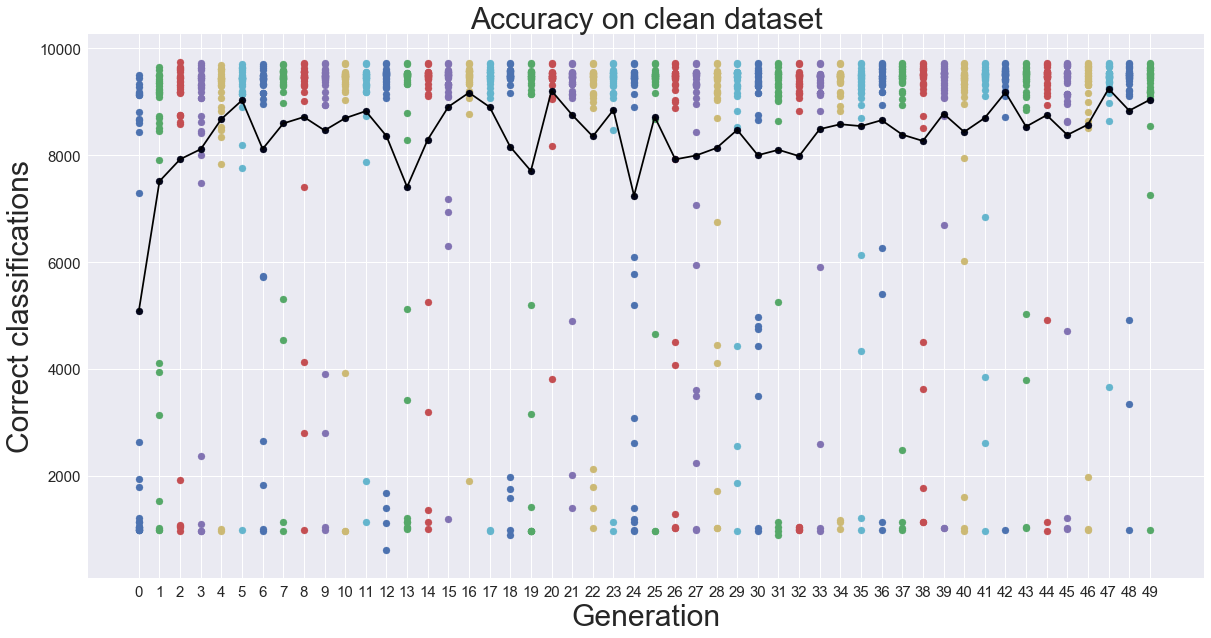

In [35]:
progressplotter(testing, clean=True)

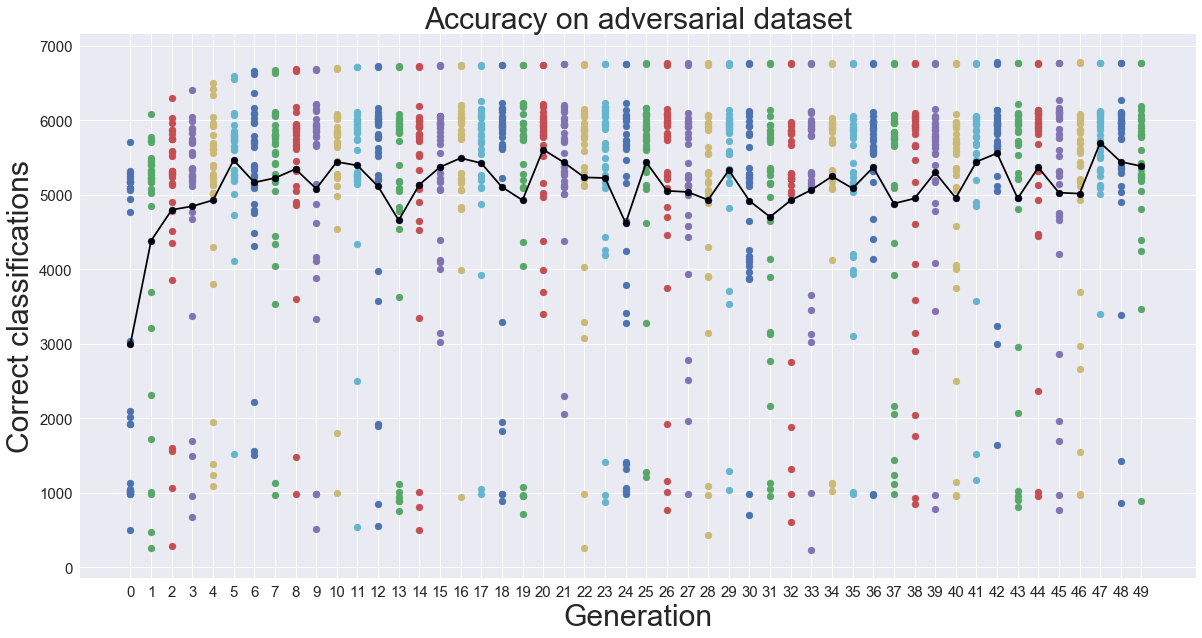

In [36]:
progressplotter(testing)

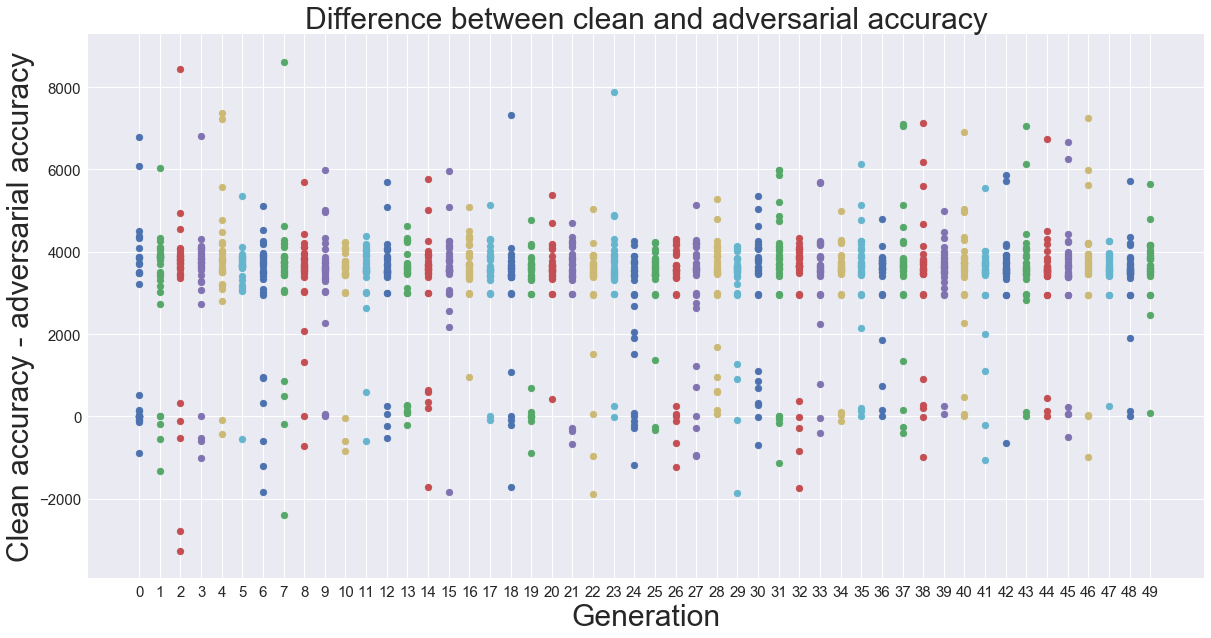

In [54]:
diffplotter(testing)

In [69]:
best = {}
for gen in testing.test_results:
    best[gen] = {}
    best_index = np.argmax(testing.test_results[gen]['correct'])
    best[gen]['net'] = best_index
    best[gen]['clean'] = testing.test_results[gen]['clean_correct'][best_index]
    best[gen]['adversarial'] = testing.test_results[gen]['correct'][best_index]
    
    genome = testing.genome_history[gen][best_index]
    
    best[gen]['layers'] = genome['nb_layers']
    best[gen]['dropout'] = genome['layers'][0]['dropout_rate']
    best[gen]['nb_units'] = genome['layers'][0]['nb_units']
    best[gen]['optimizer'] = genome['optimizer']
    best[gen]['activation'] = genome['layers'][0]['activation']

In [62]:
testing.genome_history

{1: [{'layers': [{'activation': 'sigmoid',
     'dropout_rate': 0.28323364021148517,
     'nb_units': 1373},
    {'activation': 'sigmoid',
     'dropout_rate': 0.25509228190746064,
     'nb_units': 1340}],
   'lr': 0.06427254008154393,
   'nb_layers': 2,
   'optimizer': 'sgd',
   'weight_decay': 0.0002753997209281461},
  {'layers': [{'activation': 'relu',
     'dropout_rate': 0.0669129728133823,
     'nb_units': 604},
    {'activation': 'sigmoid',
     'dropout_rate': 0.655310530343693,
     'nb_units': 1602}],
   'lr': 0.05144533337227822,
   'nb_layers': 2,
   'optimizer': 'sgd',
   'weight_decay': 0.0002853956959314776},
  {'layers': [{'activation': 'linear',
     'dropout_rate': 0.11518572146020258,
     'nb_units': 845}],
   'lr': 0.08125986188400582,
   'nb_layers': 1,
   'optimizer': 'rmsprop',
   'weight_decay': 0.0002847975186345795},
  {'layers': [{'activation': 'sigmoid',
     'dropout_rate': 0.43655477684174115,
     'nb_units': 535}],
   'lr': 0.06971638675395699,
   'nb_l

In [70]:
best

{1: {'activation': 'relu',
  'adversarial': 5713,
  'clean': 9451,
  'dropout': 0.5346674336081404,
  'layers': 1,
  'nb_units': 567,
  'net': 28,
  'optimizer': 'adadelta'},
 2: {'activation': 'relu',
  'adversarial': 6089,
  'clean': 9588,
  'dropout': 0.5346674336081404,
  'layers': 1,
  'nb_units': 567,
  'net': 0,
  'optimizer': 'adadelta'},
 3: {'activation': 'relu',
  'adversarial': 6296,
  'clean': 9658,
  'dropout': 0.5346674336081404,
  'layers': 1,
  'nb_units': 567,
  'net': 0,
  'optimizer': 'adadelta'},
 4: {'activation': 'relu',
  'adversarial': 6407,
  'clean': 9683,
  'dropout': 0.5346674336081404,
  'layers': 1,
  'nb_units': 567,
  'net': 0,
  'optimizer': 'adadelta'},
 5: {'activation': 'relu',
  'adversarial': 6496,
  'clean': 9697,
  'dropout': 0.5346674336081404,
  'layers': 1,
  'nb_units': 567,
  'net': 0,
  'optimizer': 'adadelta'},
 6: {'activation': 'relu',
  'adversarial': 6591,
  'clean': 9650,
  'dropout': 0.5346674336081404,
  'layers': 1,
  'nb_units': 

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# Tests

In [27]:
def rebuild_from_save(optimizer, generation, position):
    
    genome = optimizer.genome_history[generation][position]
    
    net = NetFromBuildInfo(genome)
    
    net.load_state_dict(torch.load(r"D:\Models\NeuroEvolution\{}-{}".format(generation, position)))
    
    return net.cuda()

In [28]:
def sanity_check(optimizer, test_loader):
    
    for generation in optimizer.test_results:
        print('generation {}: \n'.format(generation))
        for i, result in enumerate(optimizer.test_results[generation]['correct']):
            
            mod = rebuild_from_save(optimizer, generation, i)
            _, rebuild_result = test(mod, test_loader)
            
            if result == rebuild_result:
                print("result = {}, rebuild result = {}. (equal)".format(result, rebuild_result))
            else:
                print("result = {}, rebuild result = {}. (different!!)".format(result, rebuild_result))

In [29]:
sanity_check(testing, adversarial_loader)

generation 1: 



FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Models\\NeuroEvolution\\1-0'